# DNA standards

DNA standards are synthetic cDNA oligos complementary to RNA strand terminated with
  - `*A`: A-only tail with varying lengths (0, 15, 30, 60, 90 or 120);  
  - `*U`, `5G`, `5C`: 30 As followerd by either Us (1, 3 or 5), Gs (5) or Cs (5); 
  - `IntG`: 15 As followed by 3 GAAAA repeats

We prefiltered only the reads for which
the alignment starts in expected reference posittion (+/-1).
For example, for 0A, 60A and 120A,
the alignments should start at position
1, 61 and 121 of the reference, respectively 
(adding 12 bases that are typically lost from 5'-end by ONT sequencing). 


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from glob import glob

## Tail length

PolyTailor underestimates tail length, therefore we normalise it by a factor `a` optionally adding `b`. 

Additionally, you can choose to include only reads with selected filters ie `OK` and `no_pT`. 

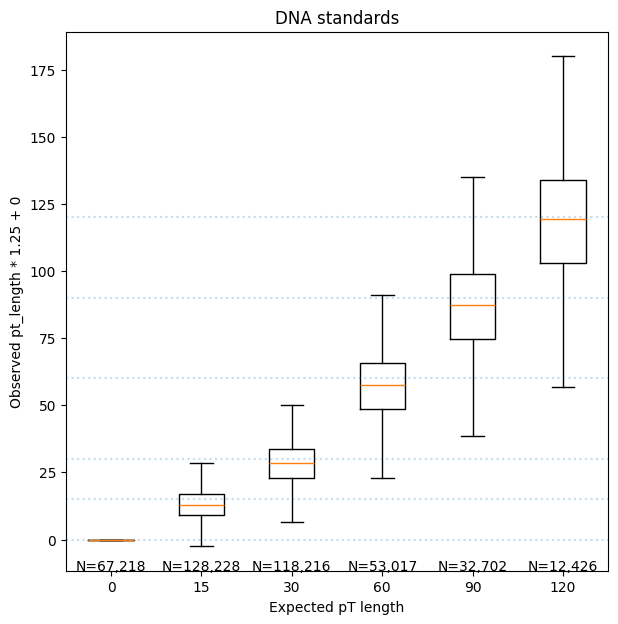

In [125]:
y = "pt_length"
a, b = 1.25, 0
#a, b = 1.25, 2
data = []
fn = "../test/minimap2/DNA_standards/%sA.bam.pT.tsv.gz"
pt_lengths = (0, 15, 30, 60, 90, 120)
for pt_len in pt_lengths:
    df = pd.read_csv(fn%pt_len, sep="\t") 
    #sizes = df.loc[df["filter"].isin(("OK", "no_pT")), y].to_numpy() * a + b
    sizes = df[y].to_numpy() * a + b
    data.append(sizes)

fig, ax = plt.subplots(figsize=(7, 7))
_ = ax.boxplot(data, positions=np.arange(len(data)), labels=pt_lengths, showfliers=False)
ymin, _  = ax.get_ylim()
for tick, label in enumerate(ax.get_xticklabels()):
    ax.text(tick, ymin, f"N={len(data[tick]):,}", color='black',  horizontalalignment="center") # medians[tick]
_ = ax.hlines(pt_lengths, *ax.get_xlim(), ls=":", alpha=0.25)
ax.set_xlabel("Expected pT length"); 
ax.set_ylabel(f"Observed {y} * {a} + {b}"); 
ax.set_title("DNA standards")
fig.savefig("DNA_standards.length.png")
fig.savefig("DNA_standards.length.pdf")

## composition

- heterogenous tail bases
- tail ends

In [243]:
!pip install logomaker
import logomaker
from collections import Counter

bases = 'ACGT'
base2idx = {b: i for i, b in enumerate(bases)}

fn = "../test/minimap2/DNA_standards/%s.bam.pT.tsv.gz"

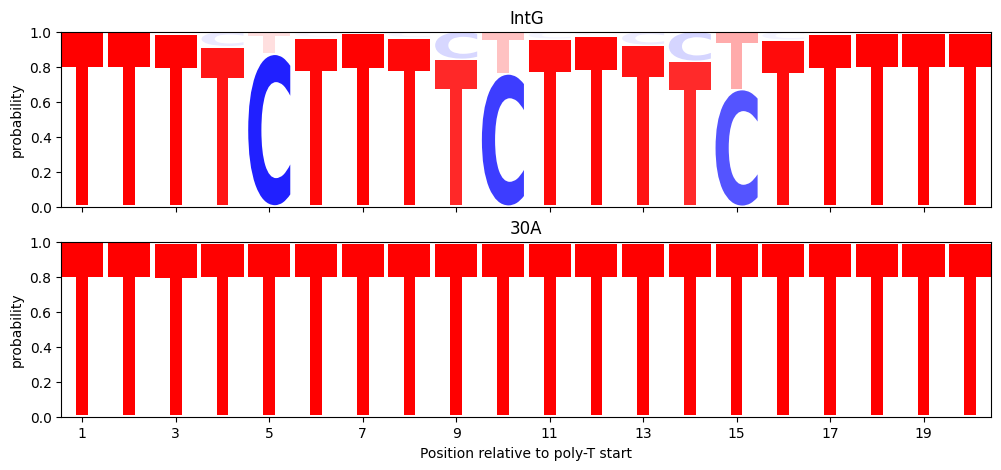

In [282]:
samples = ["IntG", "30A"]
N = 20
fig, axes = plt.subplots(len(samples), figsize=(12, 1+2*len(samples)), sharex="col")
for ax, s in zip(axes, samples): 
    df = pd.read_csv(fn%s, sep="\t")
    # get counts
    counts = np.zeros((len(bases), N), dtype='int')
    for seq in df.loc[df['filter']=="OK", 'pt_seq'].to_list():
        for i, b in enumerate(seq):
            if i==N: break
            counts[base2idx[b], i] += 1
    # and freq
    freq = counts / counts.sum(axis=0)
    # df
    probs = pd.DataFrame(freq.T, columns=list(bases), index=range(1, N+1)); df
    # write logo
    logo = logomaker.Logo(probs, ax=ax, width=.9, vpad=.02, fade_probabilities=True, stack_order='small_on_top',)
    ax.set_title(s)
    ax.set_ylabel("probability")
ax.set_xticks(range(1, N+1, 2))
ax.set_xlabel("Position relative to poly-T start")
fig.savefig("DNA_standards.iternal.png")
fig.savefig("DNA_standards.iternal.pdf")

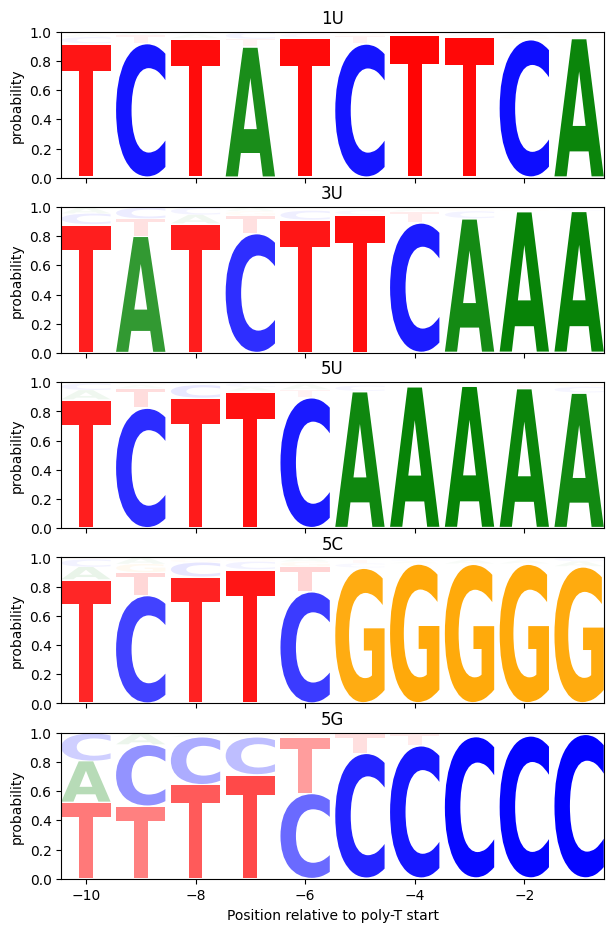

In [250]:
ends = ["1U", "3U", "5U", "5C", "5G"]

fig, axes = plt.subplots(len(ends), figsize=(7, 1+2*len(ends)), sharex="col")
for ax, end in zip(axes, ends): 
    df = pd.read_csv(fn%end, sep="\t")
    # get array 
    x = np.array(list(map(list, df.loc[df['filter']=="not_continuous", 'before_pt'].to_numpy('U10'))))
    # get counts
    counts = np.zeros((len(bases), x.shape[1]), dtype='int')
    for i in range(x.shape[1]):
        c = Counter(x[:, i])
        counts[:, i] = [c[b] for b in bases]
    # and freq
    freq = counts / counts.sum(axis=0)
    # df
    df = pd.DataFrame(freq.T, columns=list(bases), index=range(-x.shape[1], 0)); df
    # write logo
    logo = logomaker.Logo(df, ax=ax, width=.9, vpad=.02, fade_probabilities=True, stack_order='small_on_top',)
    ax.set_title(end)
    ax.set_ylabel("probability")
    #break
ax.set_xlabel("Position relative to poly-T start")
fig.savefig("DNA_standards.ends.png")
fig.savefig("DNA_standards.ends.pdf")